In [78]:
import os
import numpy as np
import rasterio
from data_utils import reproject_img, plot_with_mask, plot_image
from rasterio.windows import Window
from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.plot import show, reshape_as_image, reshape_as_raster
from tqdm import tqdm

In [79]:
%reload_ext autoreload
%autoreload 2

**Configure dataset parameters**

In [80]:
output_image_size = 256

dst_crs = 'EPSG:3006'

dataset_path = '..\\data\\SentinelLandCoverSweden\\' 
mask_path = os.path.join(dataset_path, 'mask\\nmd2018bas_ogeneraliserad_v1_1.tif')

In [81]:
requests = [folder for folder in os.listdir(os.path.join(dataset_path, 'raw'))]
raw_paths = {folder: os.path.join(dataset_path, 'raw\\') + folder + '\\response.tiff' for folder in requests}

Reprojecting image...
Adding land cover mask...
Plotting water mask on RGB image...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Splitting image into output size...
Saving 64 images...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [01:08<00:00,  1.07s/it]


Reprojecting image...
Adding land cover mask...
Plotting water mask on RGB image...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Splitting image into output size...
Saving 72 images...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [01:06<00:00,  1.08it/s]


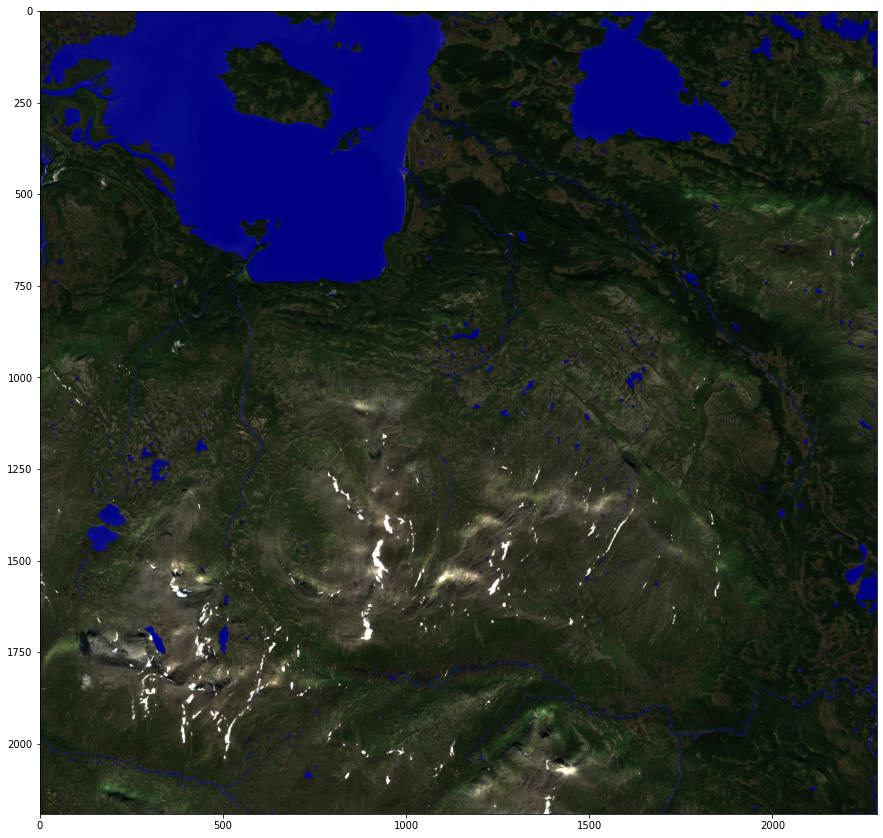

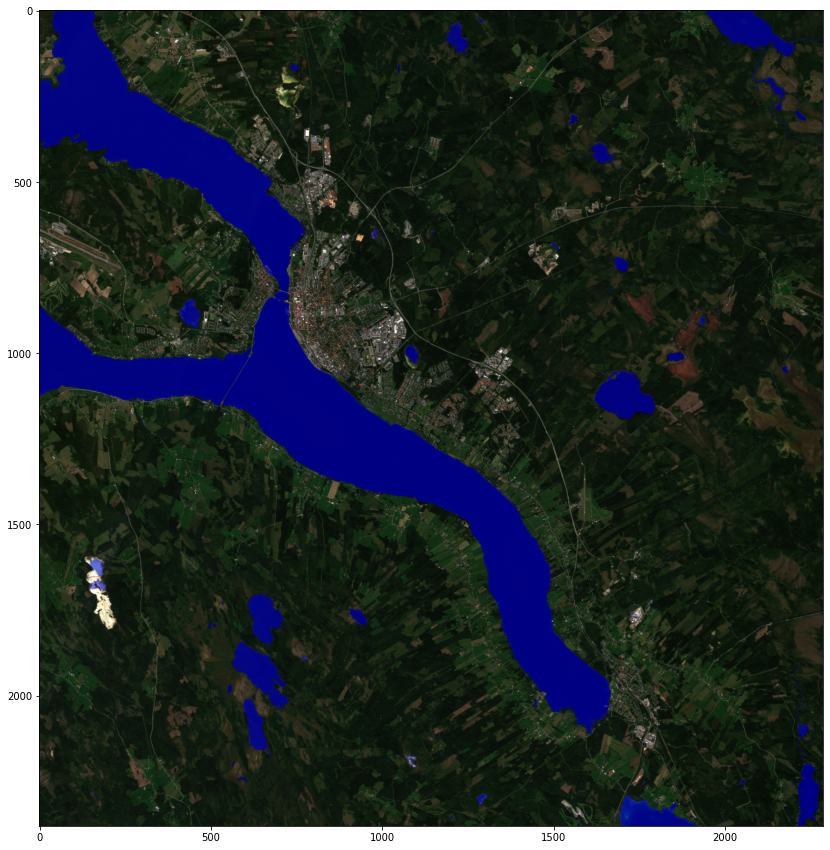

In [94]:
for r in requests:
    # Reproject each image
    print('Reprojecting image...')
    with rasterio.open(raw_paths[r]) as src:
        reproject_img(src, os.path.join(dataset_path, 'reprojected\\{}.tiff'.format(r)), dst_crs)

    print('Adding land cover mask...')
    # Add the land cover label to each image
    with rasterio.open(os.path.join(dataset_path, 'reprojected\\{}.tiff'.format(r)), 'r') as img_ds:
        with rasterio.open(mask_path) as mask_ds:
            extents, _ = next(shapes(np.zeros_like(img_ds.read(1)), transform=img_ds.profile['transform']))
            mask_cropped, mask_cropped_transf = mask(mask_ds, [extents], crop=True)
            img_cropped= img_ds.read()

            # Remove edges without data that were introduced during reprojection
            zero_mask = img_cropped[1] + img_cropped[2] + img_cropped[3]
            zero_mask = np.where(zero_mask==0, 1, 0)

            col_sums = zero_mask.sum(axis=0)
            row_sums = zero_mask.sum(axis=1)

            d_col_sums = np.diff(col_sums)
            d_row_sums = np.diff(row_sums)

            x_min = np.where(d_col_sums < -15, 1, 0).sum() + 1
            x_max = np.where(d_col_sums < 15, 1, 0).sum() - 1
            y_min = np.where(d_row_sums < -15, 1, 0).sum() + 1
            y_max = np.where(d_row_sums < 15, 1, 0).sum() - 1

            img_cropped = reshape_as_raster(reshape_as_image(img_cropped)[y_min:y_max, x_min: x_max])
            mask_cropped = reshape_as_raster(reshape_as_image(mask_cropped)[y_min:y_max, x_min: x_max])

            print('Plotting water mask on RGB image...')
            plot_masked_image(reshape_as_image(img_cropped), reshape_as_image(mask_cropped), mask_code=61)

            # Combine image and mask and split into square images
            print('Splitting image into output size...')
            data_img = reshape_as_image(np.concatenate((img_cropped, mask_cropped)))
            corner_xs = [i*output_image_size for i in range(data_img.shape[1]//output_image_size)]
            corner_ys = [i*output_image_size for i in range(data_img.shape[0]//output_image_size)]
            corner_indexes = [(y, x) for x in corner_xs for y in corner_ys]

            data = np.asarray([data_img[ci[0]:ci[0]+output_image_size, ci[1]:ci[1]+output_image_size] for ci in corner_indexes])

    print('Saving {} images...'.format(len(data)))
    tbar = tqdm(data, ncols=130)
    for i, img in enumerate(tbar):
        img = img.reshape((img.shape[0]*img.shape[1], img.shape[-1]))
        np.savetxt(os.path.join(dataset_path, 'dataset\\{}_{}.csv'.format(str(r), str(i))), img, delimiter=',')

In [95]:
# To get back as 3D image:
from numpy import genfromtxt
img = genfromtxt(dataset_path + 'dataset\\' + '{}_0.csv'.format(r), delimiter=',')
img = img.reshape(256, 256, 14)

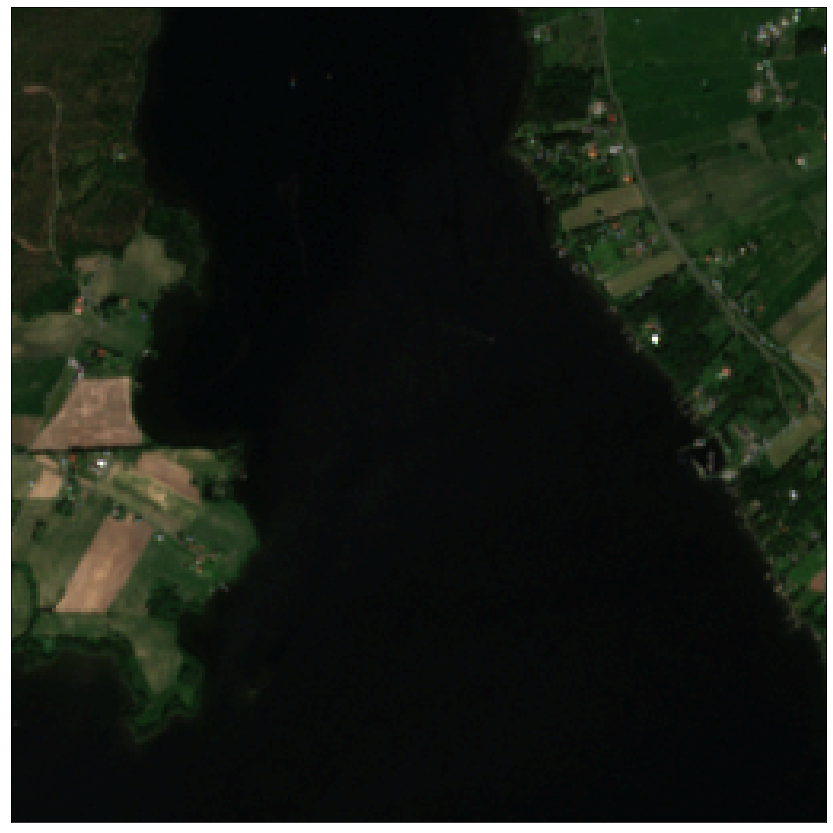

In [96]:
plot_image(np.moveaxis(np.moveaxis(img, -1, 0)[[3, 2, 1]], 0, -1), factor=3.5 / 255, clip_range=(0, 1))

In [4]:
import  json

json.dumps({'test': 2.00})

'{"test": 2.0}'

In [5]:
print({'test': 2.00})

{'test': 2.0}


In [103]:
land_cover_map = {
    ele[0]: {
        'name': ele[1],
        'description': ele[2],
        'rgb': ele[3]
    }
    for ele in data
}

In [108]:
import pickle
with open('..\\data\\SentinelLandCoverSweden\\land_cover_map.pickle', 'wb') as output_file:
    pickle.dump(land_cover_map, output_file)